# Creating a Gaussian Generative Model to Classify Wine Bottles to Wineries

## Introduction

In this notebook, a dataset will be studied that contains quantitative information about 178 wine bottles originating from three wineries. Such quantitiative information includes the alcohol content of each bottle, along with 12 other numerical indicators.

The aim of this notebook is to use the quantitative information for each of the wine bottles to predict which winery it was produced from. The predictions will be made using a <i>univariate Gaussian generative model</i>.

For a given wine bottle, the generative model assigns a probability to each of the three wineries that represents the probability that the given wine bottle was produced at that winery. The wine bottle is then predicted to originate from the winery that has the largest probability.

## Getting Started

The files `wine.data` needs to be downloaded from http://archive.ics.uci.edu/ml/machine-learning-databases/wine/ and placed in the directory `./data`. For ease, this dataset has been already uploaded to this repository.

Import the libraries that will be used in the notebook. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from scipy.stats import norm, multivariate_normal

## Reading, cleaning and exploring the data

Read the data and put into a Pandas dataframe. 

In [2]:
X = pd.read_csv('./data/wine.data', sep=",", header=None)

Check to see the contents of the first few rows of the dataset.

In [3]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


The first column is the label of which winery the wine came from: Winery 1, Winery 2 and Winery 3. The other 13 columns are the 13 features of each wine bottle are shown below:


In [4]:
features = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols', 
            'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
            'OD280/OD315', 'Proline']

Set the columns to have appropriate names.

In [5]:
X.columns = ['Winery'] + features

Check to see if there is any missing data in our dataset.

In [6]:
X.isnull().any()


Winery                  False
Alcohol                 False
Malic acid              False
Ash                     False
Alcalinity of ash       False
Magnesium               False
Total phenols           False
Flavanoids              False
Nonflavanoid phenols    False
Proanthocyanins         False
Color intensity         False
Hue                     False
OD280/OD315             False
Proline                 False
dtype: bool

Check to see how many data points there are.

In [7]:
X.shape[0]

178

Check to see the frequency of the number of bottles belonging to the three different wineries.

In [8]:
X['Winery'].value_counts()

2    71
1    59
3    48
Name: Winery, dtype: int64

Define our target labels.

In [9]:
y = X['Winery']

Use the function `train_test_split` from the package `sklearn.model_selection` to split the data into train data and test data. 33% of the data will be left for the purposes of testing the model.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Creating a normal distribution for the alcohol content of the first winery

A normal distribution needs to be created that models each feature for a given winery in the training data. In order to create this normal distribution, the mean and standard deviation need to be determined.

In [11]:
def get_mean_and_std(feature_name, winery_number):
    """ For example, get_mean_and_std('Alcohol', 1) returns the mean and standard
        deviation for alcohol content of wines coming from Winery 1 for the training data."""

    winery_filter = X_train['Winery'] == winery_number
    
    df = X_train[winery_filter][feature_name]
    
    mean = df.mean()
    std = df.std()
    
    return mean, std

A normal distribution can be created to model, for example, the alcohol content of the wine bottles from Winery 1.

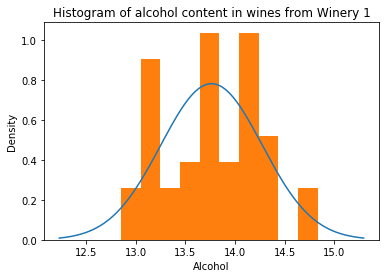

In [12]:
feature_name = 'Alcohol'
winery_number = 1

mean, std = get_mean_and_std(feature_name, winery_number)

winery_filter = X_train['Winery'] == winery_number

# Create a list of x value coordinates that range from 3 std above and below the mean. 
x_axis = np.arange(mean-3*std, mean+3*std, 0.001)

# Use norm from.pdf scipy.stats to determine the values on the bell curve for each of 
# the values on the x_axis list. Plot these values.
plt.plot(x_axis, norm.pdf(x_axis, mean, std))

# Plot the distribution of the given feature for the given winery. 
plt.hist(X_train[winery_filter][feature_name], bins=10, density=True)

# Add labels, title and then plot.
plt.xlabel(feature_name)
plt.ylabel('Density')
plt.title('Histogram of alcohol content in wines from Winery 1')

plt.show()

If a feature is chosen, it would be ideal if a graph could be displayed that showed three normal distributions corresponding to how the three different wineries differ in this given feature.

In [13]:
def plot_feature_for_all_wineries(feature_name):
    """Calling plot_feature_for_all_wineries('Alcohol') will display three normal
       distributions for the alcohol content for the three wineries for the training data."""

    # Determine the lower and upper limits of the plot. 
    # Do this first by determining the means and stds for each of the wineries for the
    # given feature.
    
    means = []
    stds = []
    
    for winery_number in [1,2,3]:
        mean, std = get_mean_and_std(feature_name, winery_number)
        means.append(mean)
        stds.append(std)
    
    lower_bounds = []
    upper_bounds = []
    
    for i in [0,1,2]:
        
        lower_bounds.append(means[i]-3*stds[i])
        upper_bounds.append(means[i]+3*stds[i])
        
    # The x_axis will be a list containing values from the lowest lower bound and
    # the highest upper bound.
    
    x_axis = np.arange(min(lower_bounds), max(upper_bounds), 0.001)

    # Plot the bell curves for each of the three wineries for the given feature.
    
    for i in [1,2,3]:
        mean, std = get_mean_and_std(feature_name, i)
        plt.plot(x_axis, norm.pdf(x_axis, mean, std), label='Winery ' + str(i))

    # Add labels, title, legend and then plot.
    
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.title('{} density for the three wineries'.format(feature_name))
    
    plt.legend()
    plt.show()
    
    return


A plot of the three wineries can be made, for example, for the Alcohol feature. 

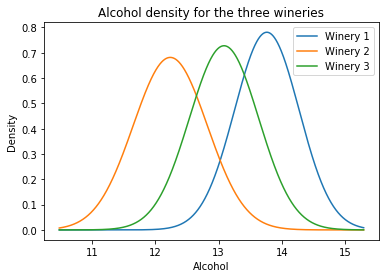

In [14]:
plot_feature_for_all_wineries('Alcohol')

A similar plot can be made for the Flavanoids feature. It can be seen that Winery 1 and Winery 3 are quite distinct.

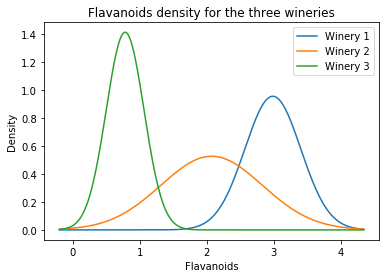

In [15]:
plot_feature_for_all_wineries('Flavanoids')

## Fitting a Gaussian Generative Model 

Given the X_train dataset, if a feature were to be selected, a gaussian generative model could be created by first determining the mean, standard deviation and pi values for each of the three wineries. The pi value for a given winery represents the fraction of total wines that are from this given winery.

In [16]:
def fit_generative_model(df, feature_name):
    """The fit_generative_model takes a dataframe, such as X_train, and a given feature and 
       returns three lists. The first list is a list of the means for the three wineries.
       The other two lists contain the standard deviation and pi values for the
       three wineries."""
     
    # Initialise the lists that will be returned by the function.
    
    means = np.zeros(3)
    stds = np.zeros(3)
    pis = np.zeros(3)
    
    total_number_of_wines = df.shape[0]
    
    for i in [0,1,2]:     
    
        # NB: The loop and list is zero indexed, but the name of the winery is not.
        number_of_wines_in_winery = df[df['Winery'] == i+1].shape[0]                      
    
        pis[i] = number_of_wines_in_winery/total_number_of_wines
    
        means[i], stds[i] = get_mean_and_std(feature_name, i+1)
    
    return means, stds, pis

Now that the means, standard deviations and pi values can be determined for each feature and for each winery, predictions can be made for each of the wine bottles in the test data.

Given a wine bottle from the test data, it will be classified as the winery that maximises the probability:

probability = (pi value of the winery) x (the wines 'location' on the bell curve of the winery) 

In [17]:
def predict_model(df, feature_name):
    """The function predict_model takes in a dataframe, such as X_test, and a given feature,
    and returns a list of predictions using a Gaussian generative model."""
    
    # Determine the means, stds and pi values for the given feature for each 
    # of the three wineries.
    means, stds, pis = fit_generative_model(df, feature_name)
  
    # Create a test_data list that contains the data values of the given feature from the df.
    test_data = df[feature_name].tolist()
    predictions = []
    
    for point in test_data:
        
        # Initialise a list that will contain the three probabilities. 
        probabilities = np.zeros(3)
        
        # Loop through each of the wineries, zero indexed, and determine the probability of
        # it belonging to the winery. 
        for i in [0, 1, 2]:
            
            probabilities[i] = pis[i] * norm.pdf(point, means[i], stds[i])
            
        # The predicted label will be the winery that has the maximum probability. 
        prediction = np.argmax(probabilities)
        
        # The loop and list is zero indexed, but the name of the winery is not.
        # This is why one is added.
        predictions.append(prediction+1)
        
    return predictions



For example, the alcohol content feature can be seen to have an accuracy score of approximately 69% for this given "random" partition of test data.

In [18]:
predictions = predict_model(X_test, 'Alcohol')
correct_labels = y_test

accuracy_score(correct_labels, predictions)

0.6949152542372882

It would be interesting to know which feature predicts the test data the best. 

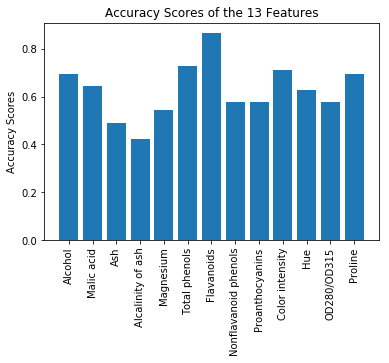

In [19]:
# Initialise a list that will contain the accuracy scores for each of the features.
accuracy_scores = []

for feature in features:
    
    predictions = predict_model(X_test, feature)
    correct_labels = y_test.tolist()

    accuracy_scores.append(accuracy_score(correct_labels, predictions))

# Create a list to show where the x positions of the bar chart will be located. 
x = range(len(accuracy_scores))

# Plot the bar chart. 
plt.bar(x, accuracy_scores)
plt.xticks(x, features, rotation='vertical')
plt.ylabel('Accuracy Scores')
plt.title('Accuracy Scores of the 13 Features')
plt.show()

It can be seen from the plot above that the best performing feature is the 'Flavanoids' feature that was shown previously. The exact accuracy is:


In [20]:
accuracy_scores[6]

0.864406779661017

This makes sense because is was previously seen that the normal distributions for each of the three wineries varied quite significantly for the flavanoids content for each of the three wineries. 

It can be seen from the plot above that the feature 'Alcalinity of ash' is the worst performing. The exact accuracy is:

In [21]:
accuracy_scores[3]

0.423728813559322

It can be seen from the plot above that the feature 'Alcalinity of ash' is the worst performing.
A graph of the normal distributions for the feature 'Alcalinity of ash' for the three wineries for the training data can illuminate the reason why this is the case.

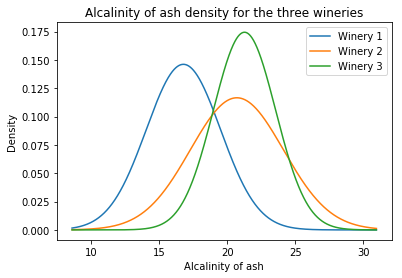

In [22]:
plot_feature_for_all_wineries('Alcalinity of ash')

One can see why the 'Alcalinity of ash' feature is not a good feature for classification. The three wineries are clustered too close together for classification to be effective.

## Conclusion

In this notebook, a Gaussian generative model was created to classify the origins of wine bottles from three wineries. The model used only one feature and hence was univariate. It was found that the 'Flavanoids' feature of the wine bottles is the most effective feature to classify using the Gaussian generative model. This feature was able to predict the test data with 86% accuracy.
Naturally, improvements can be made from this classification accuracy. One could consider a multi-variate generative model that considers multiple features at once in an effort to improve the classificaiton accuracy.

## References

Dasgupta, S. (2019). EDX Course: Machine Learning Fundamentals. UCSanDiegoX. Retrieved from https://www.edx.org/course/machine-learning-fundamentals-3

Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 